# Step 2: Mean, Standard Deviation and Moving Average 
### This script averages all measurements for a particular specimen and filters noise using a modifiable moving average. It also calculates the standard deviation for each frequency.
#### Data should be jump corrected and in .txt format

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import re

#constants
moving_average_cicles=35
markersize = 2
max_wavelength =2450

# Set the directory path where the files are located
file_directory = r'E:\CICIMA\VINICIO\VINICIO\2023-03-CICIMAUCR-2-REFLECTANCE\jump_corrected_files'
save_directory = file_directory.replace(r"\jump_corrected_files", "")
report_directory = file_directory.replace(r"\jump_corrected_files", r"\report")


### Functions 

In [2]:
re1 = r"([a-zA-Z\d]+)(?:-\d)*(?:.Sample)*.(?:txt)*(?:ASC)*"
#Names are in the form CODE-MEASUREMENTNUMBER.TXT
p = re.compile(re1)
m = p.match("INBUCR0222-1.Sample.Sample.ASC")
m.group(1)

'INBUCR0222'

In [3]:
def get_metadata_and_dataframe(file_location):
     #definitions
    #Logic to read ASCII data
    import os
    import pandas as pd
    import re
    
    def get_sample_code_from_filename(row_str, file_location):
        print("string")
        print(file_location)
        filename = os.path.basename(file_location)
        re1 = r"([a-zA-Z\d]+)(?:-\d)*(?:.Sample)*.(?:txt)*(?:ASC)*"
        #Names are in the form CODE-MEASUREMENTNUMBER.TXT
        p = re.compile(re1)
        m = p.match(filename)
        print(f"match filename: {m}")
        if m:
            print(f"group 1: {m.group(1)}")
            return(m.group(1))
        return get_sample_code(file_str)

    def get_sample_code(row_str):
        #Tries to get the sample code from the file, if it does not match
        #it tries to get it from the filename. 
        print("string")
        print(row_str)
        re1 = r"([a-zA-Z\d]+)(?:-\d)*(?:.Sample)*.(?:txt)*(?:ASC)*"
        #Names are in the form CODE-MEASUREMENTNUMBER.TXT
        p = re.compile(re1)
        m = p.match(row_str)
        print(f"match: {m}")
        if m:
            return(m.group(1))
        else: 
            ""

    def responses(str):
        re1 = "\d+/(\d+,\d+) \d+,\d+/(\d+,\d+)"
        p = re.compile(re1)
        m= p.match(str)
        if m:
            return m.group(1),m.group(2)    
        else:
            return "",""
    def attenuator_settings(str):
        re1 = "S:(\d+,\d+) R:(\d+,\d+)"
        p = re.compile(re1)
        m= p.match(str)
        if m:
            return m.group(1),m.group(2)    
        else:
            return "",""
    def slit_pmt_aperture(str):
        re1 = "\d+/servo \d+,\d+/(\d+,\d+)"
        p = re.compile(re1)
        m= p.match(str)
        if m:
            return m.group(1)    
        else:
            return ""
    #Initializa metadata dict
    metadata = {}
    
    #Read header
    lines = []
    with open(file_location) as myfile:
        lines = myfile.readlines()[0:90] 
    metadata["header"] = "".join(lines)
    
    
    #read_metadata
    f = open(file_location)
    
    df = pd.DataFrame()
    with f as data_file:
        for index, row in enumerate(data_file): #0-89

            row_str = row.strip()
            if index +1 == 3: #Filename and extension
                metadata["filename"]= row_str
                metadata["code"] = get_sample_code_from_filename(row_str, file_location)
            if index + 1 == 4: #date DD/MM/YYYY
                metadata["date"]= row_str
            if index + 1 == 5:#Time HH:MM:SS.SS
                metadata["time"]= row_str
            if index + 1 == 8:#user
                metadata["user"]= row_str
            if index + 1 == 9:#description
                metadata["description"]= row_str
            if index + 1 == 10:#minimum wavelength
                metadata["minimum_wavelength"]= row_str
            if index + 1 == 12:#equipment name
                metadata["equipment"]= row_str
            if index + 1 == 13:#equipment series
                metadata["series"]= row_str
            if index + 1 == 14:#data visualizer version, equipment version, date and time
                metadata["software"]= row_str
            if index + 1 == 21:#Operating mode
                metadata["operating_mode"]= row_str
            if index + 1 == 22: #Number of cycles
                metadata["cycles"]= row_str
            if index + 1 == 32: #range/servo
                metadata["slit_pmt"]= slit_pmt_aperture(row_str)
            if index + 1 == 33:
                metadata["response_ingaas"], metadata["response_pmt"]= responses(row_str)
            if index + 1 == 35: #pmt gain, if 0 is automatic
                metadata["pmt_gain"]= row_str
            if index + 1 == 36: #InGaAs detector gain
                metadata["ingaas_gain"]= row_str
            if index + 1 == 42:#monochromator wavelength nm
                metadata["monochromator_change"]= row_str
            if index + 1 == 43:#lamp change wavelength
                metadata["lamp_change"]= row_str
            if index + 1 == 44:#pmt wavelength
                metadata["pmt_change"]= row_str
            if index + 1 == 45:#beam selector
                metadata["beam_selector"]= row_str
            if index + 1 == 46:
                metadata["cbm"]= row_str
            if index + 1 == 47: #cbd status, on/off
                metadata["cbd_status"]= row_str
            if index + 1 == 48: #attenuator percentage
                metadata["attenuator_sample"], metadata["attenuator_reference"]= attenuator_settings(row_str)
            if index + 1 == 49:
                metadata["polarizer"]= row_str
            if index + 1 == 80:
                metadata["units"]= row_str
            if index + 1 == 81:
                metadata["measuring_mode"]= row_str
            if index + 1 == 84:
                metadata["maximum_wavelength"]= row_str
            if index + 1 == 85:
                metadata["step"]= row_str
            if index + 1 == 86:
                metadata["number_of_datapoints"]= row_str
            if index + 1 == 88:
                metadata["maximum_measurement"]= row_str
            if index + 1 == 89:
                metadata["minimum_measurement"]= row_str
            if index +1 == 90:
                break
        df = pd.read_csv(f, sep="\t", decimal =",", names=["wavelength", metadata["measuring_mode"]])
        f.close()
        return metadata, df

In [4]:
def get_files_with_same_name(directory):
    #get files in directory
    files = os.listdir(directory)
    
    sample_names = []
    re1 = r"([a-zA-Z\d]+)(?:-\d)*(?:.Sample)*.(?:txt)*(?:ASC)*"
    #Names are in the form CODE-MEASUREMENTNUMBER.TXT
    for file in files:
        print(file)
        p = re.compile(re1)
        m = p.match(file)
        if m:
            sample_names.append(m.group(1))

    return set(sample_names)




In [5]:
def mean_and_moving_avg2(directory,save_directory):
    #print("test")
    for code in get_files_with_same_name(directory):
        
        # Get a list of all .txt files containing the specified code in their names
        files = [file for file in os.listdir(directory) if file.endswith('.txt') and code in file]

        #If files is not an empty list:
        if len(files): 

            # Create an empty list to store dataframes
            dataframes = []

            # Read each file, create dataframes, and plot them
            for file in files:

                #filename
                #print(file)
                #file path
                file_path = os.path.join(directory, file)

                #get metadata and dataframe
                metadata, df = get_metadata_and_dataframe(file_path)

                #metadata info
                measuring_mode = metadata["measuring_mode"]
                sample_name = metadata["code"] #.replace(".ASC", "").replace(".txt", "").replace(".Sample", "")

                # Read the file into a pandas DataFrame

                #df = pd.read_csv(file_path, sep='\t', skiprows=90, decimal = ",",names=['wavelength', measuring_mode], encoding='latin1')

                #convert columns to float
                df['wavelength'] = df['wavelength'].astype(float)
                df[measuring_mode] = df[measuring_mode].astype(float)

                # Append the dataframe to the list
                dataframes.append(df)

                # Plot the dataframe
                #plt.figure(figsize=(8, 6))
                #plt.plot(df['wavelength'], df[measuring_mode])
                #plt.xlabel('frequency')
                #plt.ylabel(measuring_mode)
                #plt.title(f'Plot of {sample_name}')
                #plt.show()

            # Calculate the average of all dataframes
            average_df = pd.concat(dataframes).groupby('wavelength').mean().reset_index()
            std_dev_df = pd.concat(dataframes).groupby('wavelength').std().reset_index()

            #Moving average
            average_df[measuring_mode] = average_df[measuring_mode].rolling(moving_average_cicles).mean().dropna()

            #standard deviation
            std_plot = std_dev_df.plot(x='wavelength', y=measuring_mode, kind='scatter', s=markersize, title = sample_name + " std dev", figsize = (8, 6))

            #save figures
            #pdf.savefig()
            #close plot
            plt.close()
            #median_df.plot(x='frequency', y='transflectance', kind='scatter', s=markersize, title = directory + "\\" + substring + "_mean_and_mov_avg.txt")
            #mean is preferred to median because the results have less noise

            #SAVE FILE
            #Convert to numpy
            average_np = average_df.to_numpy()
            std_dev_np = std_dev_df.to_numpy()

            #Create new folder
            avg_new_path = save_directory + "\\average\\"
            std_dev_new_path = save_directory + "\\std_dev\\"

            if not os.path.exists(avg_new_path):
                os.mkdir(avg_new_path)
            if not os.path.exists(std_dev_new_path):
                os.mkdir(std_dev_new_path)

            #creates new filename
            print(f"sample name: {sample_name}")
            new_avg_archive_name = avg_new_path + sample_name+'.txt'
            new_std_dev_archive_name = std_dev_new_path + sample_name+'.txt'

            #print(new_avg_archive_name)
            #saves files
            np.savetxt(new_avg_archive_name, average_np,fmt = "%.6f", delimiter="\t", header=metadata["header"], comments='')
            np.savetxt(new_std_dev_archive_name, std_dev_np,fmt = "%.6f", delimiter="\t", header=metadata["header"], comments='')
            #print("fin de la iteracion")

            def delete_blank_row(archive_name):
                with open(archive_name, "r") as f:
                    data = f.read()
                with open(archive_name, "w") as f:
                    f.write(data.replace("#DATA\n","#DATA"))

            delete_blank_row(new_avg_archive_name)
            delete_blank_row(new_std_dev_archive_name)
            # #delete empty row after #DATA
            # #for new_avg_archive_name
            # with open(new_avg_archive_name, "r") as f:
            # data = f.read()
            # with open(new_avg_archive_name, "w") as f:
            # f.write(data.replace("#DATA\n","#DATA"))
            # #for new_std_dev_archive_name
            
        

### Create files with average and std deviations for measurements selected

In [6]:
mean_and_moving_avg2(file_directory, save_directory)

CICIMAUCR0001-1.txt
CICIMAUCR0006-1.txt
string
E:\CICIMA\VINICIO\VINICIO\2023-03-CICIMAUCR-2-REFLECTANCE\jump_corrected_files\CICIMAUCR0006-1.txt
match filename: <re.Match object; span=(0, 19), match='CICIMAUCR0006-1.txt'>
group 1: CICIMAUCR0006
sample name: CICIMAUCR0006
string
E:\CICIMA\VINICIO\VINICIO\2023-03-CICIMAUCR-2-REFLECTANCE\jump_corrected_files\CICIMAUCR0001-1.txt
match filename: <re.Match object; span=(0, 19), match='CICIMAUCR0001-1.txt'>
group 1: CICIMAUCR0001
sample name: CICIMAUCR0001


### Save plot averages

#### Save images

string
E:\CICIMA\VINICIO\VINICIO\2023-03-CICIMAUCR-2-REFLECTANCE\average\CICIMAUCR0001.txt
match filename: <re.Match object; span=(0, 17), match='CICIMAUCR0001.txt'>
group 1: CICIMAUCR0001
string
E:\CICIMA\VINICIO\VINICIO\2023-03-CICIMAUCR-2-REFLECTANCE\average\CICIMAUCR0006.txt
match filename: <re.Match object; span=(0, 17), match='CICIMAUCR0006.txt'>
group 1: CICIMAUCR0006


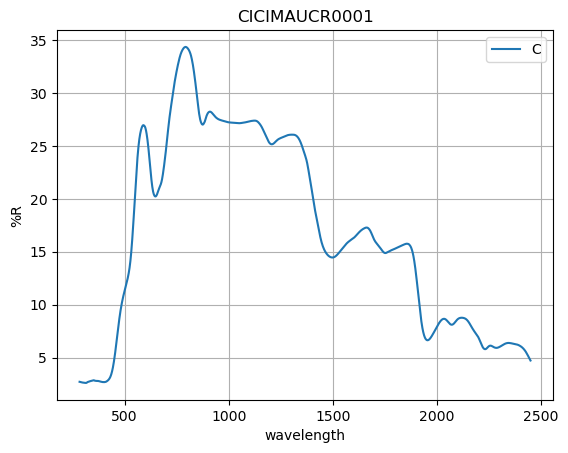

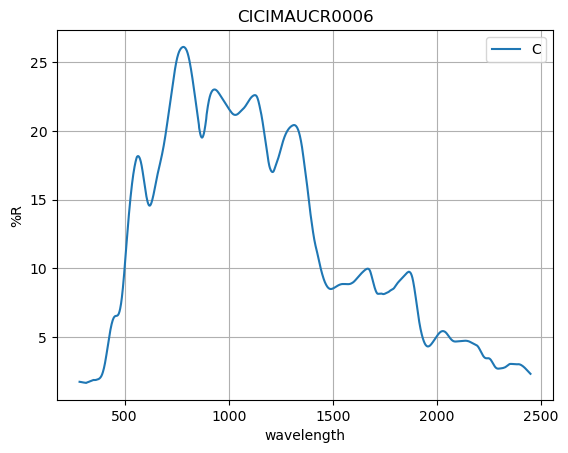

In [7]:
current_dir = save_directory + "\\average"
for file in os.listdir(current_dir):
    #print(file)
    #variables
    path = current_dir +"\\"+file
    
    #read file
    metadata, df = get_metadata_and_dataframe(path)
    
    #df = pd.read_csv(path, decimal = ",", skiprows = 90, names =["wavelength", get_metadata(path)["measuring_mode"]], encoding = "latin1", delimiter="\t")
    
    #convert datatypes to float
    df["wavelength"] = df["wavelength"].astype(float)
    df[metadata["measuring_mode"]] = df[metadata["measuring_mode"]].astype(float)
    
    #Drop nas
    df = df.dropna()
    
    #filter all data over max_wavelength nm
    
    df = df[ df["wavelength"] < max_wavelength]
   
    #plot 
    ax = df.plot("wavelength", markersize = markersize, grid=True)
    fig = ax.get_figure()
    plt.xlabel("wavelength")
    plt.ylabel(metadata["measuring_mode"])
    plt.title(metadata["code"])
    plt.legend(metadata["filename"])
    fig.savefig("test 2-26.pdf")

In [8]:
import pandas as pd
#get genus and species
#read consolidated collection
unified_collection_path = r"E:\CICIMA\databases\unified.txt"
consolidated_collection = pd.read_csv(unified_collection_path, sep="\t", decimal =".", header=0, encoding="iso-8859-1") # Assuming the file is in CSV format
consolidated_collection

def get_species(code):
    return consolidated_collection[consolidated_collection["code"] ==code].squeeze()["species"]
def get_genus(code):
    return consolidated_collection[consolidated_collection["code"] ==code].squeeze()["genus"]
get_genus("CICIMAUCR0001")

'Chrysina'

#### Save pdf

In [9]:
import matplotlib

if not os.path.exists(report_directory):
        os.mkdir(report_directory)
        
new_file = report_directory + "\\" + 'spectra_average_report.pdf'


        
with matplotlib.backends.backend_pdf.PdfPages(new_file) as pdf:
    counterA = 1
    counterB = 0
    current_dir = save_directory + "\\average"
    
    
            
    for file in os.listdir(current_dir):
        #print(file)
        #variables
        path = current_dir +"\\"+file
        metadata, df = get_metadata_and_dataframe(path)
        code = metadata["code"]
        species = get_species(code)
        genus = get_genus(code)
        #read file
        #df = pd.read_csv(path, decimal = ",", skiprows = 90, names =["wavelength", get_metadata(path)["measuring_mode"]], encoding = "latin1", delimiter="\t")
        
        #convert datatypes to float
        df["wavelength"] = df["wavelength"].astype(float)
        df[metadata["measuring_mode"]] = df[metadata["measuring_mode"]].astype(float)
        
        #Drop nas
        df = df.dropna()

        #filter all data over max_wavelength nm

        df = df[ df["wavelength"] < max_wavelength]

        avg_plot = df.plot(x='wavelength', y=metadata["measuring_mode"], kind='scatter', s=markersize, title = f"Figure {counterA}.{counterB} " + (code) + f" {genus} {species}", figsize = (8, 6), grid= True)
        avg_plot.set_xlabel("Wavelength [nm] ")
        avg_plot.set_ylabel(f'{ metadata["measuring_mode"] }')
        
        #save figures
        pdf.savefig()
        
        #close plot
        plt.close()
        
        #increase figure counter
        counterB = counterB+1
    
    
    

string
E:\CICIMA\VINICIO\VINICIO\2023-03-CICIMAUCR-2-REFLECTANCE\average\CICIMAUCR0001.txt
match filename: <re.Match object; span=(0, 17), match='CICIMAUCR0001.txt'>
group 1: CICIMAUCR0001
string
E:\CICIMA\VINICIO\VINICIO\2023-03-CICIMAUCR-2-REFLECTANCE\average\CICIMAUCR0006.txt
match filename: <re.Match object; span=(0, 17), match='CICIMAUCR0006.txt'>
group 1: CICIMAUCR0006
